#### Fonctions de base

read_rheology > ./Carbopol_Malvern.csv is a Malvern file
_malvern_laos > Stress ratio 2.38e+04 (Nm/Pa), strain ratio 1.05e+01 (1/rad)
------------- Step list in DataFrame --------------------
  * Step n°0 	 :                        Pre Shear Initial	 is a                 | Duration :     300.00 s | Total time is :     411.30 s
  * Step n°1 	 :                              Pre Shear R	 is a                 | Duration :      60.00 s | Total time is :     471.30 s
  * Step n°2 	 :                                   Rest R	 is a                 | Duration :      20.00 s | Total time is :     491.30 s
  * Step n°3 	 :                          Flow Curve Down	 is a                 | Duration :     290.30 s | Total time is :     781.60 s
  * Step n°4 	 :                            Flow Curve Up	 is a                 | Duration :     290.30 s | Total time is :    1072.00 s
  * Step n°5 	 :              Oscillation Frequency Table	 is a                 | Duration :    2040.00 s | Total time is :

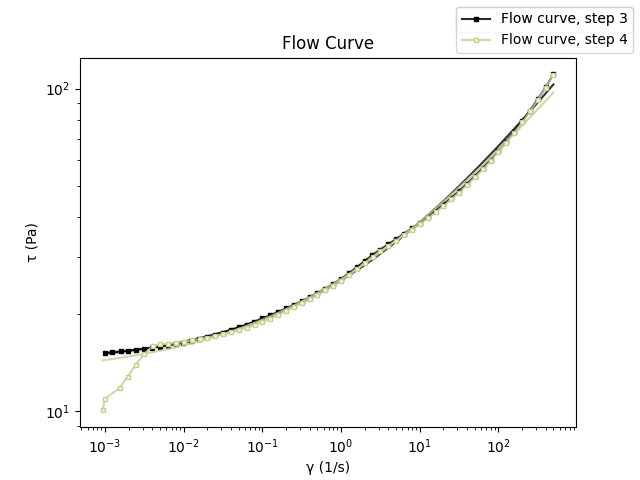

In [8]:
import rheol_functions as rh

# Load either file
# file = './Carbopol_AntonPaar.csv'
file = './Carbopol_Malvern.csv'

data = rh.read_rheology(file)                       # Read the file
rh.list_steps(data)                                 # List all the steps
data = rh.assign_steps(data, [3,4], 'flowcurve')    # Say that steps 3 and 4 are `flowcurve`s
flowcurves = rh.slice(data,'flowcurve')             # Select step 3 and 4 that have previously been assigned as `flowcurve`
fig, fit = rh.plot_flowcurve(flowcurves)            # Plot the flow curves of steps 3 and 4

-------------------------------------------------

### Your workspace !

Your text here, comments and code below in the Python cell.

plot_fsweep > Warning : Cannot confirm that step 5 is a frequency sweep


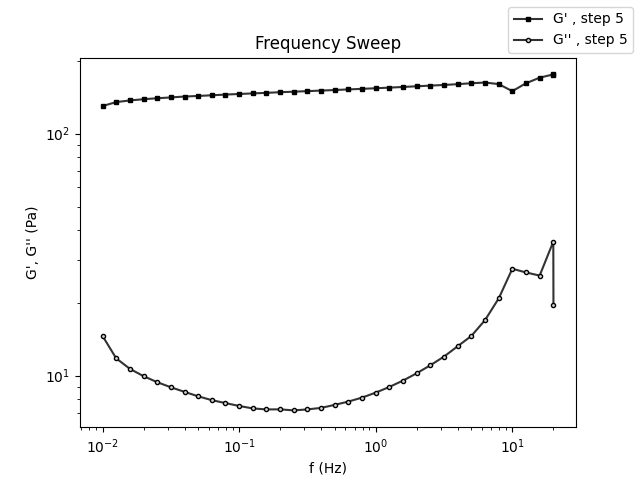

0

In [9]:
rh.plot_fsweep(rh.slice(data, 5)) # :-)

-------------------------------------------------

#### LAOS (Anton Paar)

The Anton Paar LAOS Step n°7 has multiple oscillation amplitudes, from low to high values. Let's plot them altogether with a different color for each plot, and without additional normalisation. The script here takes advantage of the `proj_fourier()` and `build_fourier()` functions allowing easy projection on Fourier __series__ (no Fourier transform here).

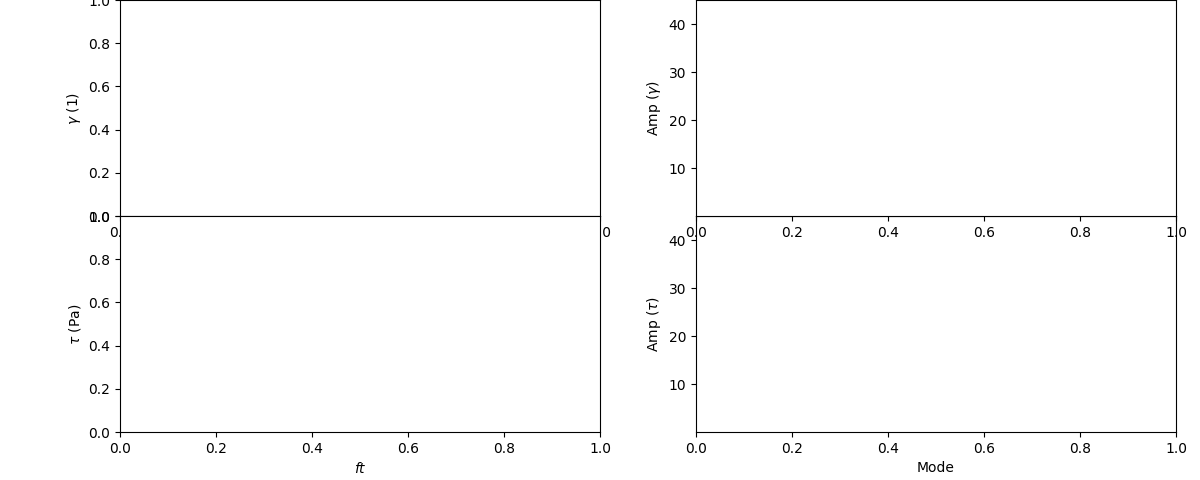

In [10]:
import numpy as np
import matplotlib.cm as cm
import matplotlib.pyplot as plt

rawlaos = data[data['raw'] & (data['step'] == 7)]
synlaos = data[~data['raw'] & (data['step'] == 7)]

cmap = cm.magma_r

%matplotlib widget

fig = plt.figure()
ax0 = fig.add_axes([0.10,0.55,0.4,0.45])
ax1 = fig.add_axes([0.10,0.10,0.4,0.45])
ax2 = fig.add_axes([0.58,0.10,0.4,0.45])
ax3 = fig.add_axes([0.58,0.55,0.4,0.45])

for pt in np.unique(rawlaos['point'][:]):
    color = 0.85*np.array(cmap(pt/8))
    select = rawlaos[rawlaos['point'] == pt]
    f = np.squeeze(np.unique(select['freq']))
    t_rebuilt = np.linspace(0, 1, len(select)) # We don't get the "raw" time ; we assume the points correspond to one period

    proj_gam = rh.proj_fourier(2*np.pi*t_rebuilt, select['raw_oscstrain'], nmodes=10)
    proj_tau = rh.proj_fourier(2*np.pi*t_rebuilt, select['raw_oscstress'], nmodes=10)
    fit_gam = rh.build_fourier(proj_gam, 2*np.pi*t_rebuilt, nmodes=10)
    fit_tau = rh.build_fourier(proj_tau, 2*np.pi*t_rebuilt, nmodes=10)

    # Plotting
    ax0.plot(t_rebuilt, select['raw_oscstrain'], '-',  color=color)
    ax0.plot(t_rebuilt, fit_gam, ':',  color=color)
    ax1.plot(t_rebuilt, select['raw_oscstress'], '-', color=color)
    ax1.plot(t_rebuilt, fit_tau, ':', color=color)
    ax2.semilogy(proj_tau['mode'][1::2], proj_tau['amp'][1::2], ':o', color=color)
    ax3.semilogy(proj_gam['mode'][1::2], proj_gam['amp'][1::2], ':o', color=color)
    ax2.semilogy(proj_tau['mode'][::2], proj_tau['amp'][::2], 'o', markeredgecolor=color, markerfacecolor='None')
    ax3.semilogy(proj_gam['mode'][::2], proj_gam['amp'][::2], 'o', markeredgecolor=color, markerfacecolor='None') 

# Format plot
ax1.set_xlabel('$f t$')
ax1.set_ylabel('$\\tau$ (Pa)')
ax0.set_ylabel('$\\gamma$ (1)')
ax2.set_xlabel('Mode')
ax2.set_ylabel('Amp ($\\tau$)')
ax3.set_ylabel('Amp ($\\gamma$)')
ax2.set_ylim([1e-3*np.max(proj_tau['mode']), 5*np.max(proj_tau['mode'])])
ax3.set_ylim([1e-3*np.max(proj_tau['mode']), 5*np.max(proj_tau['mode'])])
fig.set_figwidth(12)

### LAOS (Malvern)

The code has to be slightly different between Anton Paar and Malvern due to technical choices 
from the two manufacturers. Anton Paar does not store the "raw time" for each point and Malvern does. But Malvern "not raw" points can be anytime, whereas Anton Paar "not raw" points correspond exactly to one period (smart !). Since the "non-raw" points of Malvern are sampled a bit whenever you specified them (it usually leads to stupid sampling times). I would then advise against doing Amplitude Sweeps and Frequency Sweeps in Malvern LAOS. I would rather do individual steps with constant parameters, and then in your Python code you can loop on the steps instead of the points (which was done above) to avoid really stupid surprises. 

Here, we will work with steps 11 to 15 ; except for the loop variable, the code is essentially the same :

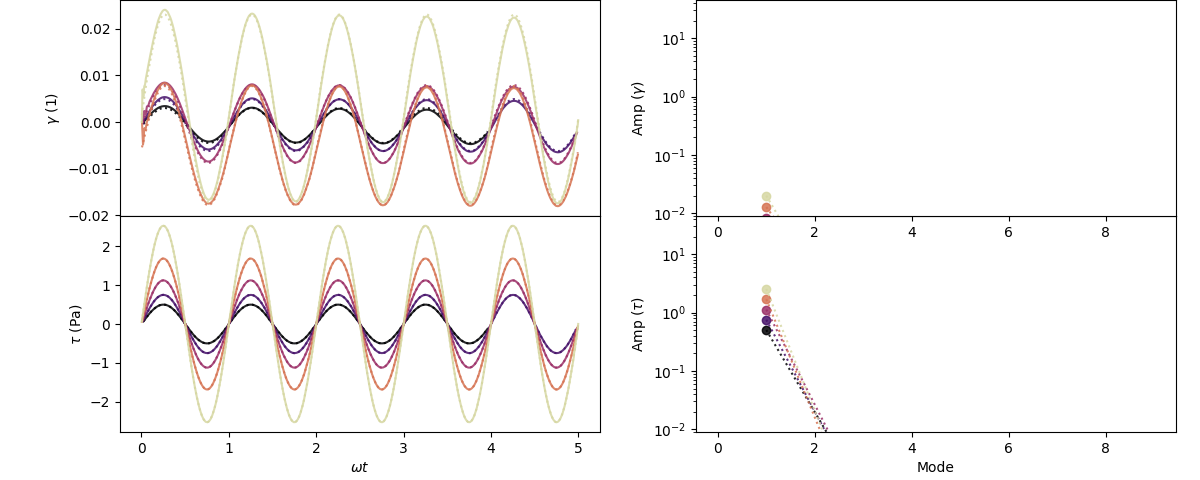

In [11]:
import numpy as np
import matplotlib.cm as cm
import matplotlib.pyplot as plt

steps = [11,12,13,14,15]
laos = rh.slice(data, steps)
rawlaos = laos[laos['raw']]
synlaos = laos[~laos['raw']]

cmap = cm.magma

fig = plt.figure()
ax0 = fig.add_axes([0.10,0.55,0.4,0.45])
ax1 = fig.add_axes([0.10,0.10,0.4,0.45])
ax2 = fig.add_axes([0.58,0.10,0.4,0.45])
ax3 = fig.add_axes([0.58,0.55,0.4,0.45])

for step in steps:
    color = 0.85*np.array(cmap((step-steps[0])/4))
    rawselect = rawlaos[rawlaos['step'] == step]
    synselect = synlaos[synlaos['step'] == step]
    f = np.squeeze(np.unique(rawselect['freq']))
    t = np.array(rawselect['time']*f)
    strs = np.array(rawselect['raw_oscstress'])
    strn = np.array(rawselect['raw_oscstrain'])

    trim_idx, = np.where(t - np.floor(np.max(t)) < 0)
    trim_idx = trim_idx[-1] # Better to trim one too many than one too few here
    t, strs, strn = t[:trim_idx], strs[:trim_idx], strn[:trim_idx]

    proj_gam = rh.proj_fourier(2*np.pi*t, strn, nmodes=10)
    proj_tau = rh.proj_fourier(2*np.pi*t, strs, nmodes=10)
    fit_gam = rh.build_fourier(proj_gam, 2*np.pi*t, nmodes=10)
    fit_tau = rh.build_fourier(proj_tau, 2*np.pi*t, nmodes=10)

    # Plotting
    ax0.plot(t, strn, '-',  color=color)
    ax0.plot(t, fit_gam, ':',  color=color)
    ax1.plot(t, strs, '-', color=color)
    ax1.plot(t, fit_tau, ':', color=color)
    ax2.semilogy(proj_tau['mode'][1::2], proj_tau['amp'][1::2], ':o', color=color)
    ax3.semilogy(proj_gam['mode'][1::2], proj_gam['amp'][1::2], ':o', color=color)
    ax2.semilogy(proj_tau['mode'][::2], proj_tau['amp'][::2], 'o', markeredgecolor=color, markerfacecolor='None')
    ax3.semilogy(proj_gam['mode'][::2], proj_gam['amp'][::2], 'o', markeredgecolor=color, markerfacecolor='None') 

# Format plot
ax1.set_xlabel('$\\omega t$')
ax1.set_ylabel('$\\tau$ (Pa)')
ax0.set_ylabel('$\\gamma$ (1)')
ax2.set_xlabel('Mode')
ax2.set_ylabel('Amp ($\\tau$)')
ax3.set_ylabel('Amp ($\\gamma$)')
ax2.set_ylim([1e-3*np.max(proj_tau['mode']), 5*np.max(proj_tau['mode'])])
ax3.set_ylim([1e-3*np.max(proj_tau['mode']), 5*np.max(proj_tau['mode'])])
fig.set_figwidth(12)

------------------------------------------------

### Debug

Writes the processed data in a `.csv` file.

In [ ]:
data.to_csv('./debug.csv')